In [1]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, SGD
from keras.layers import Input, Lambda
from keras import losses
from keras.models import model_from_json
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string, json
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
#dir = './sequence/*'
dir = './datasets/no_weight_seq/*'
alpha = list(string.ascii_uppercase)
chr2index = {alpha[i]:i for i in range(len(alpha))}

In [3]:
def chr2OH(alphabet):
    oh = [0 for i in range(len(alpha))]
    index = chr2index[alphabet]
    oh[index] = 1
    return oh

In [27]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './datasets/no_weight_seq/group'
for index in range(1, data_length+1):
    filename = file_predix + str(index) + "/*"
    print(filename)
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append(chr2OH(u[1]) + chr2OH(v[1]) +[float(w)])
            #datasets.append([chr2index[u[1]], chr2index[v[1]], float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

./datasets/no_weight_seq/group1/*
./datasets/no_weight_seq/group2/*
./datasets/no_weight_seq/group3/*
./datasets/no_weight_seq/group4/*
./datasets/no_weight_seq/group5/*
./datasets/no_weight_seq/group6/*


In [28]:
all_data[0][0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.])

In [29]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [30]:
tr_names= []
for name in train_name:
    tr_names.append(name.split('graph')[0])
    #tr_names.append(name.split('-')[0].replace('graph', ''))

In [31]:
max_sequence_length = max(sequence_length)
n_features = 3
batch_size = 32
epochs = 200
steps_per_epoch = len(x_train)

In [32]:
def custom_loss(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.kld(y_true, y_pred) # categorical_crossentropy
    return loss1 * 0.7 + loss2 * 0.3

def custom_loss1(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.categorical_crossentropy(y_true, y_pred) # categorical_crossentropy
    return loss1 * 0.7 + loss2 * 0.3

In [36]:
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)
    

inputs = Input(shape=(None, 53))
encoded = LSTM(128, return_sequences=True)(inputs)  #activation 안적으면 tanh
encoded = LSTM(64)(encoded)

decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([encoded, inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(53))(decoded)

In [37]:
def val_generator(x_val):
    idx = 0
    while True:
        yield np.array([x_val[idx]]), np.array([x_val[idx]])
        idx += 1
        if idx >= len(x_val):
            idx = 0

def train_generator(x_train):
    idx = 0
    while True:
        yield np.array([x_train[idx]]), np.array([x_train[idx]])
        idx += 1
        if idx >= len(x_train):
            idx = 0

In [ ]:
kld_ae = Model(inputs, decoded)
kld_ae.compile(loss=custom_loss, optimizer='adam')#decay=0.9
kld_hist = kld_ae.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Epoch 1/200
4297/4297 [==============================] - 55s 13ms/step - loss: 0.3211 - val_loss: 0.2592
Epoch 2/200
4297/4297 [==============================] - 53s 12ms/step - loss: 0.2712 - val_loss: 0.2703
Epoch 3/200
4297/4297 [==============================] - 56s 13ms/step - loss: 0.2535 - val_loss: 0.2639
Epoch 4/200
4297/4297 [==============================] - 57s 13ms/step - loss: 0.2501 - val_loss: 0.2425
Epoch 5/200
 213/4297 [>.............................] - ETA: 48s - loss: 0.2448

In [26]:
# MODEL SAVE
model_json = cce_ae.to_json()
filename = 'cce_no_weight_model' #input('filename: ') 
with open('models/original/cce_no_weight_model.json', 'w') as file:
    file.write(model_json)
cce_ae.save_weights('models/weights_' +  filename + '.h5')


with open('models/original/cce_no_weight_model_history.json', 'w') as f:
    json.dump(cce_hist.history, f)

In [13]:
mse_ae = Model(inputs, decoded)
mse_ae.compile(loss='mse', optimizer='adam')#decay=0.9
mse_hist = mse_ae.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Epoch 1/200
4297/4297 [==============================] - 58s 13ms/step - loss: 9.6072 - val_loss: 8.0255
Epoch 2/200
4297/4297 [==============================] - 51s 12ms/step - loss: 7.5773 - val_loss: 7.5459
Epoch 3/200
4297/4297 [==============================] - 52s 12ms/step - loss: 6.2684 - val_loss: 6.9170
Epoch 4/200
4297/4297 [==============================] - 52s 12ms/step - loss: 5.6294 - val_loss: 3.9571
Epoch 5/200
4297/4297 [==============================] - 51s 12ms/step - loss: 4.3580 - val_loss: 3.2467
Epoch 6/200
4297/4297 [==============================] - 52s 12ms/step - loss: 3.3973 - val_loss: 2.5330
Epoch 7/200
4297/4297 [==============================] - 52s 12ms/step - loss: 2.7674 - val_loss: 2.3805
Epoch 8/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.3656 - val_loss: 1.8034
Epoch 9/200
4297/4297 [==============================] - 52s 12ms/step - loss: 1.9845 - val_loss: 1.6379
Epoch 10/200
4297/4297 [==============================]

Epoch 155/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.0806 - val_loss: 0.1884
Epoch 156/200
4297/4297 [==============================] - 52s 12ms/step - loss: 0.1188 - val_loss: 0.2282
Epoch 157/200
4297/4297 [==============================] - 52s 12ms/step - loss: 0.0903 - val_loss: 0.3014
Epoch 158/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.0969 - val_loss: 0.2680
Epoch 159/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.0918 - val_loss: 0.2503
Epoch 160/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.0942 - val_loss: 0.4362
Epoch 161/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.0998 - val_loss: 0.1757
Epoch 162/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.0837 - val_loss: 0.2028
Epoch 163/200
4297/4297 [==============================] - 52s 12ms/step - loss: 0.0925 - val_loss: 0.2032
Epoch 164/200
4297/4297 [============

In [24]:
cce_inputs = Input(shape=(None, 53))
cce_encoded = LSTM(128, return_sequences=True)(cce_inputs)  #activation 안적으면 tanh
cce_encoded = LSTM(64)(cce_encoded)

cce_decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([cce_encoded, cce_inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

cce_decoded = LSTM(64, return_sequences=True)(cce_decoded)
cce_decoded = LSTM(128, return_sequences=True)(cce_decoded)
cce_decoded = TimeDistributed(Dense(53))(cce_decoded)

In [25]:
cce_ae = Model(inputs, decoded)
cce_ae.compile(loss=custom_loss1, optimizer=Adam(lr=0.0002, decay=1e-3))#Adam(lr=0.003))#decay=0.9
cce_hist = cce_ae.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))
#cce_hist = cce_ae.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Epoch 1/200
4297/4297 [==============================] - 56s 13ms/step - loss: 2.1219 - val_loss: 2.2727
Epoch 2/200
4297/4297 [==============================] - 55s 13ms/step - loss: 2.1063 - val_loss: 2.2738
Epoch 3/200
4297/4297 [==============================] - 55s 13ms/step - loss: 2.1037 - val_loss: 2.2656
Epoch 4/200
4297/4297 [==============================] - 54s 13ms/step - loss: 2.1022 - val_loss: 2.2711
Epoch 5/200
4297/4297 [==============================] - 56s 13ms/step - loss: 2.1013 - val_loss: 2.2705
Epoch 6/200
4297/4297 [==============================] - 52s 12ms/step - loss: 2.1006 - val_loss: 2.2698
Epoch 7/200
4297/4297 [==============================] - 59s 14ms/step - loss: 2.1001 - val_loss: 2.2689
Epoch 8/200
4297/4297 [==============================] - 60s 14ms/step - loss: 2.0996 - val_loss: 2.2685
Epoch 9/200
4297/4297 [==============================] - 62s 14ms/step - loss: 2.0992 - val_loss: 2.2683
Epoch 10/200
4297/4297 [==============================]

4297/4297 [==============================] - 59s 14ms/step - loss: 2.0958 - val_loss: 2.2625
Epoch 79/200
4297/4297 [==============================] - 59s 14ms/step - loss: 2.0958 - val_loss: 2.2625
Epoch 80/200
4297/4297 [==============================] - 59s 14ms/step - loss: 2.0958 - val_loss: 2.2625
Epoch 81/200
4297/4297 [==============================] - 59s 14ms/step - loss: 2.0958 - val_loss: 2.2625
Epoch 82/200
4297/4297 [==============================] - 59s 14ms/step - loss: 2.0958 - val_loss: 2.2625
Epoch 83/200
4297/4297 [==============================] - 60s 14ms/step - loss: 2.0957 - val_loss: 2.2625
Epoch 84/200
4297/4297 [==============================] - 59s 14ms/step - loss: 2.0957 - val_loss: 2.2625
Epoch 85/200
4297/4297 [==============================] - 59s 14ms/step - loss: 2.0957 - val_loss: 2.2624
Epoch 86/200
4297/4297 [==============================] - 59s 14ms/step - loss: 2.0957 - val_loss: 2.2624
Epoch 87/200
4297/4297 [==============================] - 5

Epoch 155/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0953 - val_loss: 2.2620
Epoch 156/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0953 - val_loss: 2.2620
Epoch 157/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0953 - val_loss: 2.2620
Epoch 158/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0953 - val_loss: 2.2620
Epoch 159/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0953 - val_loss: 2.2620
Epoch 160/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0953 - val_loss: 2.2620
Epoch 161/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0953 - val_loss: 2.2620
Epoch 162/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0953 - val_loss: 2.2620
Epoch 163/200
4297/4297 [==============================] - 51s 12ms/step - loss: 2.0952 - val_loss: 2.2620
Epoch 164/200
4297/4297 [============

In [81]:
kld_json = kld_ae.to_json()
mse_json = mse_ae.to_json()
cce_json = cce_ae.to_json()
models = [kld_ae, mse_ae, cce_ae]
models_json = [kld_json, mse_json, cce_json]
filenames = ['kld_oh_model', 'mse_oh_model', 'cce_oh_model']
histories = [kld_hist, mse_hist, cce_hist]

for filename, model, model_json, hist in zip(filenames, models, models_json,histories):
    with open('models/' + filename + '.json', 'w') as file:
        file.write(model_json)
    model.save_weights('models/weights_' + filename + '.h5')
    with open('models/' + filename + '_history.json', 'w') as file:
        json.dump(hist.history, file)

In [ ]:
def model_save(filename, model):
    model_json = model.to_json()
    with open('models/' + filename, 'w') as file:
        file.write(model_json)
    model.save_weights('models/weights_' + filename + '.h5')

In [18]:
# MODEL SAVE
model_json = mse_ae.to_json()
filename = '1mse_oh_model' #input('filename: ') 
with open('models/1mse_oh_model.json', 'w') as file:
    file.write(model_json)
mse_ae.save_weights('models/weights_' +  filename + '.h5')


with open('models/1mse_oh_model_hist.json', 'w') as f:
    json.dump(mse_hist.history, f)

In [19]:

with open('models/1mse_oh_model_hist.json', 'w') as f:
    json.dump(mse_hist.history, f)

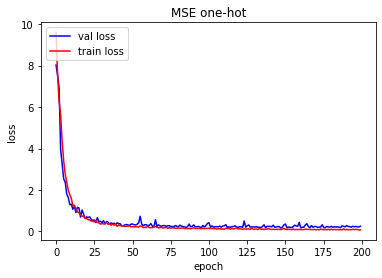

In [12]:
import matplotlib.pyplot as plt
h1 = json.load(open('models/mse_oh_model_history.json', 'r'))

fig, loss_ax = plt.subplots()

loss_ax.plot(h1['val_loss'], 'b', label='val loss')
loss_ax.plot(h1['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.title('MSE one-hot')
plt.show()

In [17]:
loaded_model = lstm_autoencoder

In [21]:
mean= 0
for xt in x_test:
    xt = xt.reshape(1, xt.shape[0], xt.shape[1])
    out = mse_ae.predict(xt)
    mean += ((xt-out)**2).mean(axis=None)
print(mean/len(x_test))

0.17943959858127367


In [37]:
filename = "mse_oh_model"
# MODEL LOAD
mse_ae = model_from_json(open('models/' +filename + '.json').read())
mse_ae.load_weights('models/weights_' + filename + '.h5')

In [16]:
encoder = Model(loaded_model.input, loaded_model.layers[3].output)

In [ ]:
test = x_test[0].reshape(1, x_test[0].shape[0], x_test[0].shape[1])
latent_vector = []
for x in x_test:
    x = x.reshape(1, x.shape[0], x.shape[1])
    latent_vector.append(encoder.predict(x)[0])

In [23]:
model_path = 'model_save/mse_kld_models/weights' + '{epoch:02d}-{loss:.4f}.h5'
early_stopping_callback = EarlyStopping(monitor='loss', patience=200)
checkpoint_callback = ModelCheckpoint(model_path, monitor='loss', verbose = 1, save_best_only = True, save_weights_only = True, mode='min', period=100)

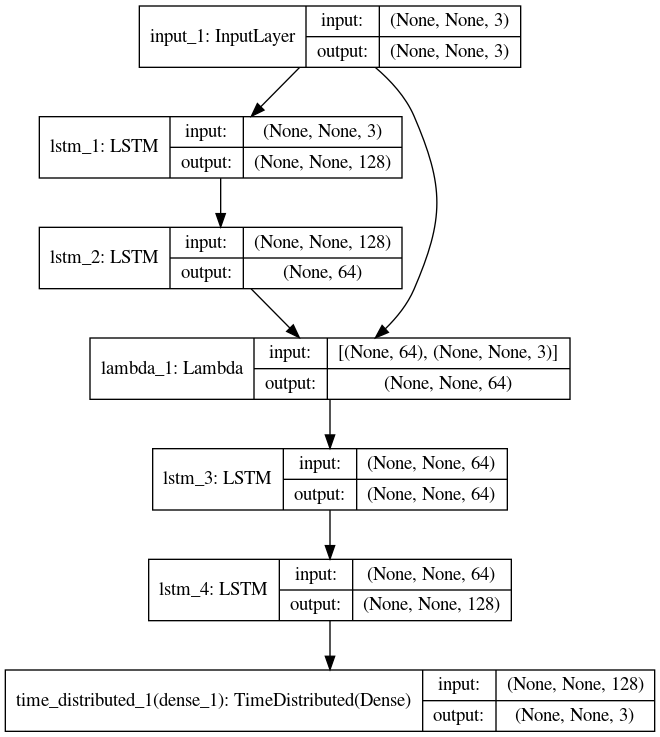

In [5]:
plot_model(loaded_model, to_file='./model.png', show_shapes=True, show_layer_names=True)